In [40]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
import subprocess as sp

model_path = "/home/beneppinger/WIPY_tests/box_model_elastic/model_init"
# output_model_path = "/home/beneppinger/WIPY_tests/box_model"
# output_model_path = "/home/beneppinger/WIPY_tests/model_init_elastic"
output_model_path = "/home/beneppinger/WIPY_tests/box_model_elastic/box_model"

sp.run(
    ["cp " +  model_path + "/* " + output_model_path],
    shell=True,
)

pars = ["x", "z", "rho", "vp", "vs"]

In [41]:
def read_fortran_binary(file_path: str) -> np.array:
    """
    Reads the fortran binary files specfems uses.
    Note that the first and last elements of data encode the length of the array.
    We remove these elements here because when dtype "float32" is used the values 
    are meaningless. When read using dtype "int32", dat[0] = dat[-1] = 4*(len(dat)-2).
    inputs: 
        file_path: the absaolute path to the binary file
    outputs: 
        dat: a NumPy array with the values of the binary file
    """

    dat: np.array = np.fromfile(file_path, dtype='float32')
    dat = dat[1:-1]
    return dat 


def write_fortran_binary(file_path: str, dat: np.array) -> None:
    """
    Writes fortran binary files that specfem can use.
    Note how we compute the buffer values (buf) and write 
    them into the binary files at either end of the data array (dat). 
    inputs: 
        file_path: the absolute path of the file to be written
        dat: the data array (usually Nx1) being written as a binary file
    """
    
    buf = np.array([4 * len(dat)], dtype="int32") 
    dat = np.array(dat, dtype="float32") 

    with open(file_path, "wb") as file: 
        buf.tofile(file) 
        dat.tofile(file) 
        buf.tofile(file) 


def load_model(model_path: str, pars: list[str]) -> dict[str: np.array]:
    """
    loads a model from binary files.
    inputs:
        model_path: the absaolute path of the folder with the binary files
        pars: the parameters from the model that will be loaded (e.g., "x", "rho", "vp", etc.)
    outputs: 
        model: a dictionary representation of a model with keys that map parameters
        to NumPy arrays
    """

    model: dict = {}

    for par in pars:
        path: list[str] = "/".join([model_path, 'proc000000_' + par + '.bin']) 
        model[par] = read_fortran_binary(path)

    return model


def write_model(model_path: str, model: dict[str: np.array]) -> None: 
    """
    Writes a dictionary representation of a model to binary files
    inputs: 
        model_path: the absolute path of the directory in which the binary files will be 
        written 
        model: the dictionary representation of a model that will be written as binary files
    """
    
    for key in model.keys():
        path: list[str] = "/".join([model_path, 'proc000000_' + key + '.bin'])
        write_fortran_binary(path, model[key])


def plot_model_fast(model: dict[str: np.array], spac: float, par: str) -> None:
    """
    Quick plotting function for dictionary representations of models
    """

    x_vec = np.arange(
        start=np.min(model['x']),
        stop=np.max(model['x'])+spac,
        step=spac
        )

    z_vec = np.arange(
        start=np.min(model['z']),
        stop=np.max(model['z'])+spac,
        step=spac
        )

    grid_x, grid_z = np.meshgrid(x_vec, z_vec,)

    f = griddata(
        points=(model['x'], model['z']),
        values=model[par],
        xi=(grid_x, grid_z),
        method='linear',
    )

    plt.pcolormesh(grid_x, grid_z, f, shading='auto', cmap="turbo")
    plt.colorbar()
    plt.gca().set_aspect(1)




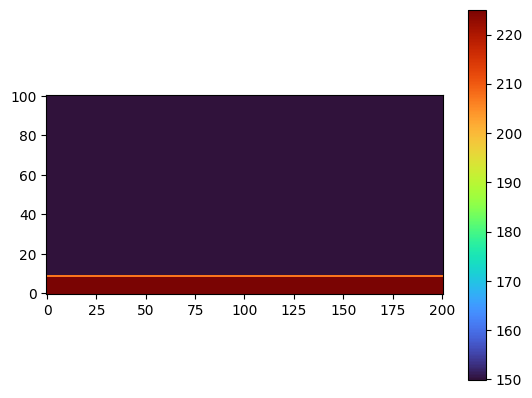

In [42]:
model = load_model(output_model_path, pars)
plot_model_fast(model, 1, 'vs')

In [43]:
# add a box anomoly to the initla model 

x_bol = ((model['x'] > 75) + 0) * ((model['x'] < 125) + 0)
z_bol = ((model['z'] > 37.5) + 0) * ((model['z'] < 62.5) + 0)
v_bol = x_bol * z_bol

pert = 150
model['vp'] = model['vp'] + pert*v_bol

write_model(output_model_path, model)

In [44]:
# add a high velocity layer to the bottom

# z_bol = ((model['z'] < 10) + 0)
# v_bol = z_bol

# pert = 150
# model['vp'] = model['vp'] + pert*v_bol

# write_model(output_model_path, model)

In [45]:
# make the vs field equal to vp/2

model["vs"] = model['vp']/2
write_model(output_model_path, model)

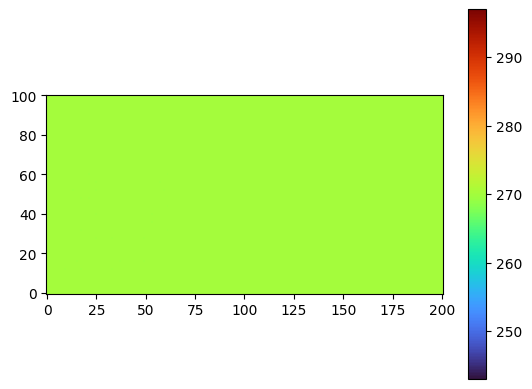

In [48]:
model = load_model(output_model_path, pars)
plot_model_fast(model, 1, 'rho')
